<a href="https://colab.research.google.com/github/GiX007/agent-labs/blob/main/04_langGraph/03_persistence_and_streaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Persistence and Streaming

## Setup

In [ ]:
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv() or '/content/OPENAI_API_KEY.env'
load_dotenv(dotenv_path)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip install langgraph langchain langchain-openai langchain-community tavily-python

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

## Agent with Memory

In [ ]:
tool = TavilySearchResults(max_results=2)

In [ ]:
class AgentState(TypedDict):
  messages: Annotated[list[AnyMessage], operator.add]

In [ ]:
# Create an in-memory SQLite storage to save agent's memory
rom langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

Overview of our Agent:

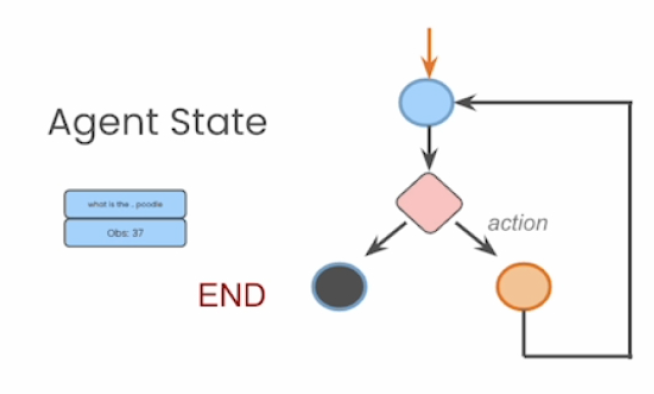

In [ ]:
class Agent:
  def __init__(self, model, tools, checkpointer, system=""):
    self.system = system

    graph = StateGraph(AgentState)
    graph.add_node("llm", self.call_openai)
    graph.add_node("action", self.take_action)
    graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
    graph.add_edge("action", "llm")
    graph.set_entry_point("llm")
    self.graph = graph.compile(checkpointer=checkpointer)

    self.tools = {t.name: t for t in tools}
    self.model = model.bind_tools(tools)

  def call_openai(self, state: AgentState):
    messages = state['messages']
    if self.system:
      messages = [SystemMessage(content=self.system)] + messages
    message = self.model.invoke(messages)
    return {'messages': [message]}

  def exists_action(self, state: AgentState):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0

  def take_action(self, state: AgentState):
    tool_calls = state['messages'][-1].tool_calls # get tool calls from the last message
    results = []
    for t in tool_calls:
      print(f"Calling: {t}")
      result = self.tools[t['name']].invoke(t['args']) # invoke the tool with given arguments
      results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result))) # wrap result in ToolMessage and add to results
    print("Back to the model!")
    return {'messages': results}

In [ ]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

Previously (```01_components.ipynb```), with ```abot = Agent(model, [tool], system=prompt)```, all messages and conversation history were stored only in the agent's internal state (```self.messages```) during runtime, so it was lost once the program ended (e.g., when the Python session or script finished running). Now, with ```abot = Agent(model, [tool], system=prompt, checkpointer=memory)```, the agent still keeps messages in its state, but it also saves them to a persistent memory (```SqliteSaver```), allowing the conversation to be stored, retrieved, or shared across sessions. The main difference is **temporary vs. persistent storage** of the agent's history.

## Run the Agent

In [ ]:
messages = [HumanMessage(content="What is the weather in sf?")]

In [ ]:
thread = {"configurable": {"thread_id": "1"}}

In [ ]:
for event in abot.graph.stream({"messages": messages}, thread):
  for v in event.values():
    print(v['messages'])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bmfLa92f6oAIKN9KvXtqbKDz', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 151, 'total_tokens': 173, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-60301aac-65ca-41ac-a873-285c90f98862-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_bmfLa92f6oAIKN9KvXtqbKDz'}])]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_bmfLa92f6oAIKN9KvXtqbKDz'}
Back t

In [ ]:
messages = [HumanMessage(content="What about in la?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
  for v in event.values():
    print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yAuVqyQyeREOFo4umJF7W8uS', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 1134, 'total_tokens': 1156, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_eb3c3cb84d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1245081a-10a2-4945-97fb-c15e3464498d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_yAuVqyQyeREOFo4umJF7W8uS'}])]}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_yAuVqyQyeREOFo4umJF7W8u

In [ ]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
  for v in event.values():
    print(v)

{'messages': [AIMessage(content="Currently, Los Angeles is warmer than San Francisco. Los Angeles has temperatures ranging from 18°C to 27°C, while San Francisco's temperatures range from 13°C to 23°C.", response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 1818, 'total_tokens': 1858, 'prompt_tokens_details': {'cached_tokens': 1792, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_eb3c3cb84d', 'finish_reason': 'stop', 'logprobs': None}, id='run-88adb3d8-48a5-4af0-a004-4e72449bfa23-0')]}


In [ ]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
  for v in event.values():
    print(v)

{'messages': [AIMessage(content="Could you please clarify what you're comparing to determine which is warmer? Are you comparing two specific locations, types of clothing, materials, or something else? Let me know so I can provide the appropriate information.", response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 149, 'total_tokens': 192, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'stop', 'logprobs': None}, id='run-4f141449-165c-4fc3-b423-9c4c6754ea1a-0')]}


When we run messages through ```abot.graph.stream()```, each message is stored in the agent's internal state (```self.messages```) and, if a checkpointer is used (like in this case), also in persistent memory. Using the same ```thread_id``` (like ```"1"```) allows the agent to continue the conversation in that thread, so it remembers all previous messages and context. Starting a new thread with a different ```thread_id``` (like ```"2"```) creates a separate conversation, meaning the agent's state for that thread is independent and does not include messages from other threads.

## Streaming tokens

In [ ]:
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver

memory = AsyncSqliteSaver.from_conn_string(":memory:")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [ ]:
messages = [HumanMessage(content="What is the weather in SF?")]
thread = {"configurable": {"thread_id": "4"}}
async for event in abot.graph.astream_events({"messages": messages}, thread, version="v1"):
  kind = event["event"]
  if kind == "on_chat_model_stream":
    content = event["data"]["chunk"].content
    if content:
      # Empty content in the context of OpenAI means that the model is asking for a tool to be invoked
      # So we only print non-empty content
      print(content, end="|")

/usr/local/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_GiHnpbt7P6kuX4g2n6imqDXI'}
Back to the model!
The| current| weather| in| San| Francisco| is| clear| and| sunny|.| The| temperatures| are| comfortable|,| with| lows| around| |13|°C| (|55|°F|)| and| highs| up| to| |23|°C| (|73|°F|).|

In this example, the agent streams its output token by token using ```astream_events()``` with an asynchronous SQLite checkpointer (```AsyncSqliteSaver```). The conversation messages are stored in the agent's state and in persistent memory, just like before. As the agent generates text, each chunk is returned as an event, and we filter for ```"on_chat_model_stream"``` events to print only the non-empty content. Empty chunks indicate that the model is requesting a tool call rather than producing text. This approach allows us to see the model's response in real time, token by token, while maintaining the conversation state asynchronously.

This approach is useful when we want real-time streaming of the model's output, for example in chat applications or interfaces where showing the response progressively improves user experience or allows immediate processing of generated tokens.